# Data Load

In [1]:
import pandas as pd
RawData = pd.read_csv("FundingProject.csv")
RawData.head(3)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1015685046,Organic Tattoo remains 10 days (Self use & cus...,Accessories,Fashion,CAD,1/1/2016,6000,12/7/2015 18:21,100.0,failed,2,CA,74.84,70.89,4253.51
1,1019043170,Handcrafted leather wallet | key holder | card...,Accessories,Fashion,EUR,1/1/2016,2000,12/11/2015 10:52,2102.0,successful,48,BE,2314.01,2282.97,2172.19
2,1036288991,The Liaisons: a new twist on the old standards,Jazz,Music,USD,1/1/2016,5000,11/9/2015 20:12,5630.0,successful,116,US,5630.00,5630.00,5000.00


In [2]:
RawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110815 entries, 0 to 110814
Data columns (total 15 columns):
ID                  110815 non-null int64
name                110814 non-null object
category            110815 non-null object
main_category       110815 non-null object
currency            110815 non-null object
deadline            110815 non-null object
goal                110815 non-null int64
launched            110815 non-null object
pledged             110815 non-null float64
state               110815 non-null object
backers             110815 non-null int64
country             110815 non-null object
usd pledged         109999 non-null float64
usd_pledged_real    110815 non-null float64
usd_goal_real       110815 non-null float64
dtypes: float64(4), int64(3), object(8)
memory usage: 12.7+ MB


# Process Data

In [3]:
import pandas as pd
ProcessedData = pd.DataFrame()

### Project status 

In [4]:
RawData["state"].describe()

count     110815
unique         6
top       failed
freq       58155
Name: state, dtype: object

In [5]:
RawData["state"].value_counts()

failed        58155
successful    38172
canceled      13178
suspended       707
undefined       596
live              7
Name: state, dtype: int64

In [6]:
# # Remap status labels to numerical values, bias starting from 2 for failures, scale to range of 1
# # At the same time, drop rows with unrelated state values or values which cannot be processed
# ProcessedData["Status"] = RawData.loc[RawData["state"].isin(["failed", "successful", "canceled", "suspended"]), "state"].map({
# #    "canceled" : 2,
#     "failed" : 2,
# #    "suspended" : 2,
#     "successful": 3,
# })

In [7]:
ProcessedData["Status"] = (RawData["pledged"] > RawData["goal"]).astype("uint8")

In [8]:
ProcessedData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110815 entries, 0 to 110814
Data columns (total 1 columns):
Status    110815 non-null uint8
dtypes: uint8(1)
memory usage: 108.3 KB


In [9]:
ProcessedData["Status"].value_counts()

0    72983
1    37832
Name: Status, dtype: int64

### Campaign length (time)

In [10]:
from datetime import datetime
ProcessedData["Duration(Days)"] = (RawData["deadline"].apply(lambda x: datetime.strptime(x, "%m/%d/%Y")) 
                                   - RawData["launched"].apply(lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M"))
                                  ).apply(lambda x: x.days + 1) # Bias one day to avoid divide by zero
ProcessedData["Duration(Days)"].describe()

count    110815.000000
mean         33.157849
std          11.640541
min           1.000000
25%          30.000000
50%          30.000000
75%          35.000000
max          90.000000
Name: Duration(Days), dtype: float64

In [60]:
ProcessedData["Duration(Days)"] = ProcessedData["Duration(Days)"].astype("uint8")

### Category and type

In [11]:
ProcessedData["Category"] = RawData["main_category"]

In [12]:
ProcessedData["Subcategory"] = RawData["category"]

In [13]:
ProcessedData["OverallCategory"] = RawData["main_category"] + RawData["category"]

In [17]:
ProcessedData["FundingGoal"] = RawData["usd_goal_real"]

In [18]:
ProcessedData["Country"] = RawData["country"]

In [19]:
# This kinda begs the question because the pledged amount determines success
#ProcessedData["FundingRate(USD/Day)"] = RawData["usd_pledged_real"] / ProcessedData["Duration(Days)"]

# Drop extra data

In [20]:
def ShowCorrelationHeatmap(DataFrame, FigureSize = (10, 10)):
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline
    
    plt.close()
    axes = plt.figure(figsize = FigureSize).add_subplot(111)
    sns.heatmap(pd.DataFrame(DataFrame.corr(method = "spearman")["Status"]).T, annot = True)

    # Fix for cutoff top and bottom (Apparently bug with matplotlib version 3.1.1)
    bottom, top = plt.ylim()
    plt.ylim(bottom + 0.5, top - 0.5)

    plt.show()

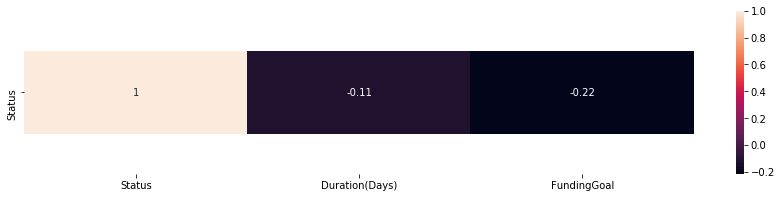

In [21]:
ShowCorrelationHeatmap(ProcessedData, FigureSize = (15, 3))

# Modeling

In [22]:
ProcessedData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110815 entries, 0 to 110814
Data columns (total 7 columns):
Status             110815 non-null uint8
Duration(Days)     110815 non-null int64
Category           110815 non-null object
Subcategory        110815 non-null object
OverallCategory    110815 non-null object
FundingGoal        110815 non-null float64
Country            110815 non-null object
dtypes: float64(1), int64(1), object(4), uint8(1)
memory usage: 5.2+ MB


In [23]:
ProcessedData.dropna(inplace = True)

In [24]:
ProcessedData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110815 entries, 0 to 110814
Data columns (total 7 columns):
Status             110815 non-null uint8
Duration(Days)     110815 non-null int64
Category           110815 non-null object
Subcategory        110815 non-null object
OverallCategory    110815 non-null object
FundingGoal        110815 non-null float64
Country            110815 non-null object
dtypes: float64(1), int64(1), object(4), uint8(1)
memory usage: 6.0+ MB


In [25]:
ProcessedData["Status"].value_counts()

0    72983
1    37832
Name: Status, dtype: int64

In [26]:
# Show dupes and null counts per column
for column in ProcessedData.columns.to_list():
    print(column, ":", ProcessedData[column].duplicated().sum(), " - " , ProcessedData[column].isnull().sum())

Status : 110813  -  0
Duration(Days) : 110750  -  0
Category : 110800  -  0
Subcategory : 110656  -  0
OverallCategory : 110645  -  0
FundingGoal : 86654  -  0
Country : 110792  -  0


## Generate baseline model without using title field

In [27]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

def AssessClassifierModels(TrainingDataColumns, TrainingDataResults, TestingDataColumns, TestingDataResults, Models_List):
    from datetime import datetime
    import pandas as pd
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

    results_list = pd.DataFrame()
    
    for modelClass in Models_List:
        startTime = datetime.now()
        print("Starting " + str(modelClass.__name__) + " at " + str(startTime))
        
        model = modelClass()
        model.fit(TrainingDataColumns, TrainingDataResults)
        predictions = model.predict(TestingDataColumns)
        
        endTime = datetime.now()
        positiveValue = TestingDataResults.max()

        results_list = results_list.append({
            "Name" : modelClass.__name__,
            "F1": f1_score(TestingDataResults, predictions, pos_label = positiveValue),
            "Accuracy": accuracy_score(TestingDataResults, predictions),
            "Precision": precision_score(TestingDataResults, predictions, pos_label = positiveValue),
            "Recall" : recall_score(TestingDataResults, predictions, pos_label = positiveValue),
            "RunTime" : str(endTime - startTime),
            "ConfusionMatrix" : confusion_matrix(TestingDataResults, predictions),
            "ModelObject": model,
        }, ignore_index = True)
    
    results_list.sort_values("F1", ascending = False, inplace = True)
    
    return results_list

In [28]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

def AssessRegressorModels(TrainingDataColumns, TrainingDataResults, TestingDataColumns, TestingDataResults, Models_List):
    from datetime import datetime
    import pandas as pd
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
    
    results_list = pd.DataFrame()
    
    for modelClass in Models_List:
        model = modelClass()
        startTime = datetime.now()
        print("Starting " + str(modelClass.__name__) + " at " + str(startTime))
        
        model.fit(TrainingDataColumns, TrainingDataResults)
        predictions = model.predict(TestingDataColumns)
        
        endTime = datetime.now()
        print("Ending " + str(modelClass.__name__) + " at " + str(endTime))
        results_list = results_list.append(pd.DataFrame(data = {
            "Name" : modelClass.__name__,
            "R2Score" : r2_score(TestingDataResults, predictions),
            "RMSE" : mean_squared_error(TestingDataResults, predictions)**0.5,
            "MAE" : mean_absolute_error(TestingDataResults, predictions),
            "RunTime" : str(endTime - startTime),
            "ModelObject" : [model],
        }), ignore_index = True)
    
    results_list.sort_values("R2Score", inplace = True, ascending = False)
    
    return results_list

In [29]:
TrainingData = pd.get_dummies(ProcessedData, drop_first = True)

In [30]:
print(datetime.now())

2020-02-06 06:23:00.429154


In [31]:
TrainingData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110815 entries, 0 to 110814
Columns: 366 entries, Status to Country_US
dtypes: float64(1), int64(1), uint8(364)
memory usage: 41.0 MB


In [32]:
print(datetime.now())

2020-02-06 06:23:00.496133


In [33]:
from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(TrainingData.drop("Status", axis = 1), TrainingData["Status"], test_size = 0.2, random_state = 13)

In [34]:
print(datetime.now())

2020-02-06 06:23:00.660081


In [35]:
RegressorResults_List = AssessRegressorModels(Train_X, Train_Y, Test_X, Test_Y, [LinearRegression, Ridge, Lasso, ExtraTreeRegressor, ElasticNet, GradientBoostingRegressor, XGBRegressor])

Starting LinearRegression at 2020-02-06 06:23:00.666079
Ending LinearRegression at 2020-02-06 06:23:01.912679
Starting Ridge at 2020-02-06 06:23:01.915679


C:\Users\root\.conda\envs\DataScience\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.59861e-18): result may not be accurate.
  overwrite_a=True).T


Ending Ridge at 2020-02-06 06:23:02.465503
Starting Lasso at 2020-02-06 06:23:02.469502
Ending Lasso at 2020-02-06 06:23:03.039319
Starting ExtraTreeRegressor at 2020-02-06 06:23:03.042318
Ending ExtraTreeRegressor at 2020-02-06 06:23:08.664520
Starting ElasticNet at 2020-02-06 06:23:08.668519
Ending ElasticNet at 2020-02-06 06:23:09.235337
Starting GradientBoostingRegressor at 2020-02-06 06:23:09.240335
Ending GradientBoostingRegressor at 2020-02-06 06:23:59.049686
Starting XGBRegressor at 2020-02-06 06:23:59.053686


C:\Users\root\.conda\envs\DataScience\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[06:23:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Ending XGBRegressor at 2020-02-06 06:24:37.284453


In [36]:
with pd.option_context("display.max_columns", None, "display.max_rows", None, "display.max_colwidth", 40):
    display(RegressorResults_List)

,Name,R2Score,RMSE,MAE,RunTime,ModelObject
6,XGBRegressor,0.150114,0.436731,0.392983,0:00:38.230767,"XGBRegressor(base_score=0.5, booster..."
5,GradientBoostingRegressor,0.149658,0.436848,0.393319,0:00:49.809351,([DecisionTreeRegressor(ccp_alpha=0....
1,Ridge,0.113790,0.445966,0.397872,0:00:00.549824,"Ridge(alpha=1.0, copy_X=True, fit_in..."
0,LinearRegression,0.113764,0.445972,0.397849,0:00:01.246600,"LinearRegression(copy_X=True, fit_in..."
4,ElasticNet,0.013378,0.470553,0.445701,0:00:00.566818,"ElasticNet(alpha=1.0, copy_X=True, f..."
2,Lasso,0.000761,0.473553,0.449190,0:00:00.569817,"Lasso(alpha=1.0, copy_X=True, fit_in..."
3,ExtraTreeRegressor,-0.371488,0.554791,0.359265,0:00:05.622202,"ExtraTreeRegressor(ccp_alpha=0.0, cr..."


In [37]:
print(datetime.now())

2020-02-06 06:24:37.373425


In [38]:
with pd.option_context("display.max_columns", None, "display.max_rows", 40, "display.max_colwidth", 80):
    display(pd.DataFrame(data = {
        "Names" : TrainingData.drop("Status", axis = 1).columns.to_list(),
        "Weight": (RegressorResults_List.loc[RegressorResults_List["Name"] == "XGBRegressor", "ModelObject"]).iloc[0].feature_importances_,
    }).sort_values(by="Weight", ascending = False))

,Names,Weight
2,Category_Comics,0.063696
151,Subcategory_Tabletop Games,0.062590
11,Category_Music,0.051794
23,Subcategory_Apps,0.042470
166,Subcategory_Web,0.037689
...,...,...
158,Subcategory_Translations,0.000000
157,Subcategory_Thrillers,0.000000
156,Subcategory_Theater,0.000000
155,Subcategory_Textiles,0.000000


In [39]:
ClassifierResults_List = AssessClassifierModels(Train_X, Train_Y, Test_X, Test_Y, [GaussianNB, MultinomialNB, BernoulliNB, RandomForestClassifier, DecisionTreeClassifier, ExtraTreesClassifier, GradientBoostingClassifier, XGBClassifier])

Starting GaussianNB at 2020-02-06 06:24:37.449401
Starting MultinomialNB at 2020-02-06 06:24:38.420090
Starting BernoulliNB at 2020-02-06 06:24:38.688004
Starting RandomForestClassifier at 2020-02-06 06:24:39.389780
Starting DecisionTreeClassifier at 2020-02-06 06:25:27.399420
Starting ExtraTreesClassifier at 2020-02-06 06:25:32.970638
Starting GradientBoostingClassifier at 2020-02-06 06:26:46.856998
Starting XGBClassifier at 2020-02-06 06:27:37.726722


In [40]:
with pd.option_context("display.max_columns", None, "display.max_rows", None, "display.max_colwidth", 40):
    display(ClassifierResults_List)

,Accuracy,ConfusionMatrix,F1,ModelObject,Name,Precision,Recall,RunTime
1,0.469882,"[[3668, 10958], [791, 6746]]",0.534527,"MultinomialNB(alpha=1.0, class_prior...",MultinomialNB,0.381044,0.895051,0:00:00.219930
0,0.392275,"[[1299, 13327], [142, 7395]]",0.523373,"GaussianNB(priors=None, var_smoothin...",GaussianNB,0.356867,0.981160,0:00:00.937699
2,0.667960,"[[11102, 3524], [3835, 3702]]",0.501524,"BernoulliNB(alpha=1.0, binarize=0.0,...",BernoulliNB,0.512317,0.491177,0:00:00.665787
3,0.676984,"[[11577, 3049], [4110, 3427]]",0.489117,(DecisionTreeClassifier(ccp_alpha=0....,RandomForestClassifier,0.529185,0.454690,0:00:47.975650
5,0.667193,"[[11481, 3145], [4231, 3306]]",0.472691,"(ExtraTreeClassifier(ccp_alpha=0.0, ...",ExtraTreesClassifier,0.512479,0.438636,0:01:13.851371
4,0.657989,"[[11299, 3327], [4253, 3284]]",0.464235,DecisionTreeClassifier(ccp_alpha=0.0...,DecisionTreeClassifier,0.496748,0.435717,0:00:05.536228
6,0.706854,"[[13556, 1070], [5427, 2110]]",0.393767,([DecisionTreeRegressor(ccp_alpha=0....,GradientBoostingClassifier,0.663522,0.279952,0:00:50.835735
7,0.704643,"[[13575, 1051], [5495, 2042]]",0.384196,"XGBClassifier(base_score=0.5, booste...",XGBClassifier,0.660200,0.270930,0:00:38.604649


In [41]:
with pd.option_context("display.max_columns", None, "display.max_rows", 40, "display.max_colwidth", 80):
    display(pd.DataFrame(data = {
        "Names" : TrainingData.drop("Status", axis = 1).columns.to_list(),
        "Weight": (ClassifierResults_List.loc[ClassifierResults_List["Name"] == "XGBClassifier", "ModelObject"]).iloc[0].feature_importances_,
    }).sort_values(by="Weight", ascending = False))

,Names,Weight
14,Category_Technology,0.101572
2,Category_Comics,0.053944
166,Subcategory_Web,0.044937
23,Subcategory_Apps,0.041802
151,Subcategory_Tabletop Games,0.040968
...,...,...
157,Subcategory_Thrillers,0.000000
156,Subcategory_Theater,0.000000
155,Subcategory_Textiles,0.000000
154,Subcategory_Television,0.000000


## Generate model using title field

### Tokenize words in title

### Determine parts of speech for each word

In [46]:
def GetTotalWordCount(TextString):
    import nltk
    import re
    wordCheck = re.compile(r"^[a-zA-Z0-9]+$")
    return len(nltk.word_tokenize(TextString))

### Calculate readability / complexity / length of text
How likely title is glossed over

Flesch Kincaid?

In [65]:
#!pip install textstat
from textstat import flesch_reading_ease as ReadabilityScore

In [64]:
RawData["name"]

0         Organic Tattoo remains 10 days (Self use & cus...
1         Handcrafted leather wallet | key holder | card...
2           The Liaisons:  a new twist on the old standards
3                        The Many Encounters of Bosley Bear
4                    Swift & Co | Innovative Men's Footwear
                                ...                        
110810    Project ChArma presents Full Circle at Dance P...
110811                              Haboob Wind - The Movie
110812                                            Honey Pot
110813    LOL Mugs with daily laugh and inspirational me...
110814                  Tapagotchi - Mobile Virtual Pet RPG
Name: name, Length: 110815, dtype: object

In [59]:
ProcessedData["Name_WordCount"] = RawData["name"].fillna("").apply(GetTotalWordCount).astype("uint8")

In [70]:
ProcessedData["Name_Readability"] = RawData["name"].fillna("").apply(ReadabilityScore)

In [71]:
ProcessedData["Name_Readability"].describe()

count    110815.000000
mean         57.993754
std          43.448520
min        -978.590000
25%          35.610000
50%          63.360000
75%          87.720000
max         206.840000
Name: Name_Readability, dtype: float64

In [80]:
with pd.option_context("display.max_colwidth", 100):
    display(RawData[ProcessedData["Name_Readability"] < -500]["name"])

2258      A SAFER                                  USB Charger-Adaptor
5445       CHALKUP,handchalk,workoutchalk,gym,fitnessgear,bodybuilding
16669                                          PoliticalRevolution.net
19076                                         #DigitalRealistStoryMode
80861                              Vestuario//cosplay//caracterización
87284                   OverTymeMusicRadio/FutureCommunicationsNetwork
93042                              D.A.H.A(demon.angel.hybrid.academy)
105543                       Mobile.Survival.Horror.Game.by.NaticaTech
Name: name, dtype: object

### Calculate sentiment of each title
How positive or optimistic titles feel

In [51]:
def GetTextSentiment(TextString):
    from textblob import TextBlob
    return TextBlob(TextString).sentiment.polarity    

In [52]:
ProcessedData["Name_SentimentValue"] = RawData["name"].fillna("").apply(GetTextSentiment)

### Calculate average TD-IDF of words in each title
How often are similar campaigns started.
Basically reader fatigue.

In [53]:
def FilterForKeyWords(TextString):
    import nltk
    import re
    from nltk.stem import WordNetLemmatizer
    from nltk.corpus.reader import wordnet
    from nltk.util import ngrams

    LemmatizerEngine = WordNetLemmatizer()
    removeWords_List = list(set([
        # Prepositions
        "of", "with", "without", "at", "from", "into", "during", "including", "until", "against", "through", "throughput",
        "towards", "to", "upon", "concerning", "in", "out", "for", "on", "below", "by", "over", "under", "despite",
        "before", "after", "between", "since", "among", "along", "following", "across", "behind", "beyond", "except",
        "but", "up", "down", "aboard", "amid", "as", "behind", "considering", "during", "inside", "minus", "off", "per",
        "versus", "via",
    ]))

    alphaCheck = re.compile(r"^[a-z]+$")

    POSTagToLemmaTag_Dict = {
        "J" : wordnet.ADJ,
        "N" : wordnet.NOUN,
        "V" : wordnet.VERB,
        "R" : wordnet.ADV,
    }

    return str([LemmatizerEngine.lemmatize(word, POSTagToLemmaTag_Dict[pos[0]]) for (word, pos) in nltk.pos_tag(nltk.word_tokenize(TextString.lower()))
            if (
                (len(word) > 1) # 
                & (alphaCheck.match(word) != None)
                & (word not in removeWords_List)
                & (pos[0] in [
                    "J",#"JJ", "JJR", "JJS", # Adjectives
                    #"N",#"NN", "NNS", "NNP", "NNPS", # Nouns
                    "R",#"RB", "RBR", "RBS", # Adverbs
                    "V",#"VB", "VBD", "VBG", "VBN", "VBP", "VBZ", #Verbs
                    ])
               )
               ])

def GetPrincipalWordCounts(DataFrame, TextColumnName):
    from sklearn.feature_extraction.text import CountVectorizer
    from datetime import datetime # For debugging performance data

    Vectorizer = CountVectorizer(lowercase = False, strip_accents = "ascii", preprocessor = FilterForKeyWords,
                                 min_df = 0.005, ngram_range = (1, 3),
                                )
    startTime = datetime.now() # For debugging performance data

    # Filter out unwanted words in each row, then create count columns for remaining words 
    WordCounts = pd.DataFrame(
        Vectorizer.fit_transform(DataFrame[TextColumnName]).toarray(), 
        columns=Vectorizer.get_feature_names(), 
        dtype = "uint8",
    )

    print(str(datetime.now() - startTime)) # For debugging performance data

    print(WordCounts.info())
    return WordCounts

def GetTFIDF(TextMatrix):
    return

In [61]:
ProcessedData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110815 entries, 0 to 110814
Data columns (total 9 columns):
Status                 110815 non-null uint8
Duration(Days)         110815 non-null uint8
Category               110815 non-null object
Subcategory            110815 non-null object
OverallCategory        110815 non-null object
FundingGoal            110815 non-null float64
Country                110815 non-null object
Name_WordCount         110815 non-null uint8
Name_SentimentValue    110815 non-null float64
dtypes: float64(2), object(4), uint8(3)
memory usage: 6.2+ MB


In [62]:
ProcessedData.describe()

,Status,Duration(Days),FundingGoal,Name_WordCount,Name_SentimentValue
count,110815.000000,110815.000000,1.108150e+05,110815.000000,110815.000000
mean,0.341398,33.157849,5.388820e+04,6.333908,0.045917
std,0.474181,11.640541,1.271062e+06,3.218028,0.208649
min,0.000000,1.000000,4.900000e-01,0.000000,-1.000000
25%,0.000000,30.000000,2.000000e+03,4.000000,0.000000
50%,0.000000,30.000000,6.214070e+03,6.000000,0.000000
75%,1.000000,35.000000,2.000000e+04,9.000000,0.000000
max,1.000000,90.000000,1.073699e+08,31.000000,1.000000
